In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

2024-06-18 21:41:12.909671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Data

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [3]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

# 2. Variational autoencoder

In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var * 0.5)*epsilon
        

In [6]:
encoder_input = layers.Input(shape=x_train[0].shape, name='e_input')
x = layers.Conv2D(32, (3,3), 2,'same', activation = 'relu')(encoder_input)
x = layers.Conv2D(64, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2D(128, (3,3), 2,'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)[1:] # shape of the tensor

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input,[z_mean,z_log_var,z], name = 'encoder')

In [7]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 e_input (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['e_input[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [8]:
decoder_input = layers.Input(shape=(2,), name='d_input')
x = layers.Dense(np.prod(shape_before_flattening) )(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2DTranspose(64, (3,3), 2,'same', activation = 'relu')(x)
x = layers.Conv2DTranspose(32, (3,3), 2,'same', activation = 'relu')(x)
decoder_output = layers.Conv2D(1,(3,3), 1, 'same', activation = 'sigmoid',name='d_output')(x)
decoder = models.Model(decoder_input, decoder_output)

In [4]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean,z_log_var,z = encoder(inputs) # encoder output
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape: # differentiation func
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction,
                                                                                    axis=(1, 2, 3)))
                                                        # computes the cross-entropy between the true binary  
                                                        # labels and the predicted probabilities
                    
                                # mean value of elements across dimensions of a tensor
            
            
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(-0.5* (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),axis=1,)) 
                # sum of elements across dimensions of a tensor
                
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction,
                                                                               axis=(1, 2, 3)))
        
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                                               axis=1,))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
            
        
        

In [5]:
vae = VAE(encoder, decoder)

NameError: name 'encoder' is not defined

In [17]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [18]:
vae.fit(
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
600/600 [==============================] - 85s 135ms/step - total_loss: 161.1696 - reconstruction_loss: 156.8176 - kl_loss: 4.3520 - val_loss: 140.9019 - val_reconstruction_loss: 136.1136 - val_kl_loss: 4.7883
Epoch 2/5
600/600 [==============================] - 86s 144ms/step - total_loss: 135.5509 - reconstruction_loss: 130.6721 - kl_loss: 4.8789 - val_loss: 137.0963 - val_reconstruction_loss: 132.1149 - val_kl_loss: 4.9815
Epoch 3/5
600/600 [==============================] - 85s 142ms/step - total_loss: 133.8230 - reconstruction_loss: 128.8182 - kl_loss: 5.0048 - val_loss: 136.6431 - val_reconstruction_loss: 131.5822 - val_kl_loss: 5.0610
Epoch 4/5
600/600 [==============================] - 82s 137ms/step - total_loss: 133.0914 - reconstruction_loss: 128.0305 - kl_loss: 5.0609 - val_loss: 136.1432 - val_reconstruction_loss: 130.8761 - val_kl_loss: 5.2671
Epoch 5/5
600/600 [==============================] - 85s 142ms/step - total_loss: 132.5215 - reconstruction_loss: 127.40

In [19]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

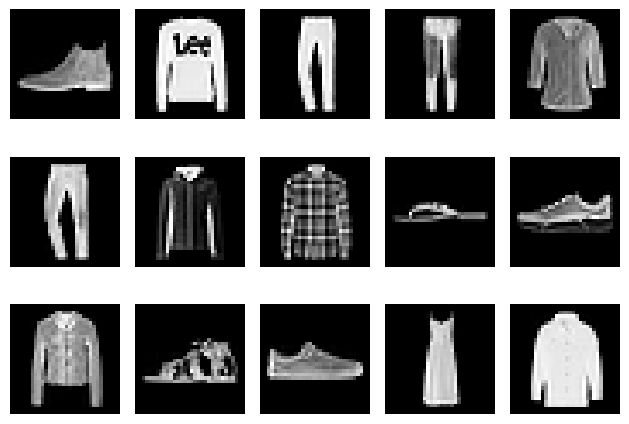

In [20]:
for i in range(15):
    plt.subplot(3, 5, i + 1) 
    plt.imshow(example_images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 [==============================] - 2s 14ms/step


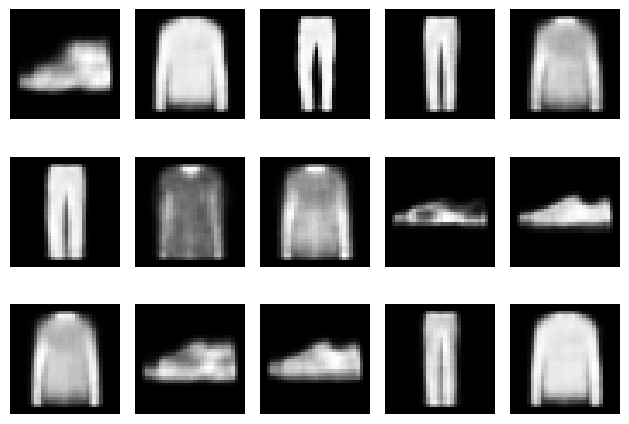

In [22]:
for i in range(15):
    plt.subplot(3, 5, i + 1) 
    plt.imshow(reconstructions[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# CelebA dataset

In [8]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [9]:
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

In [10]:
train_data = utils.image_dataset_from_directory(
    "/Users/nastyastrashnova/Study/GitReposotories/dataset/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(32, 32),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [11]:
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [12]:
train_sample = sample_batch(train)

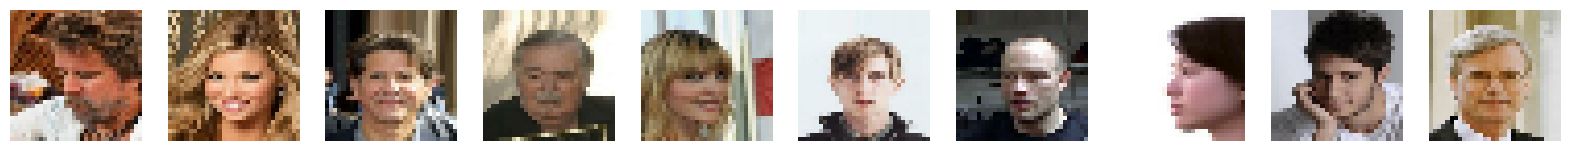

In [13]:
display(train_sample, cmap=None)

In [14]:
train_sample[0]#[0][0]

array([[[0.6425245 , 0.40784314, 0.2319853 ],
        [0.6540594 , 0.37231925, 0.17501532],
        [0.4659467 , 0.23383884, 0.08874081],
        ...,
        [0.544761  , 0.36733687, 0.26334634],
        [0.6664943 , 0.4440602 , 0.3154565 ],
        [0.5847771 , 0.33393842, 0.19641927]],

       [[0.59136415, 0.3443053 , 0.17567785],
        [0.52431065, 0.26720282, 0.101394  ],
        [0.51331955, 0.2632353 , 0.11695389],
        ...,
        [0.35359988, 0.21413909, 0.13962929],
        [0.51692325, 0.35520834, 0.2512638 ],
        [0.67635953, 0.5008119 , 0.36814108]],

       [[0.5821768 , 0.3238013 , 0.13939185],
        [0.44089308, 0.19383425, 0.05657935],
        [0.5567287 , 0.29313725, 0.12143459],
        ...,
        [0.31335402, 0.2052428 , 0.14949448],
        [0.32731694, 0.20991498, 0.1387523 ],
        [0.3432445 , 0.20988435, 0.1282935 ]],

       ...,

       [[0.88443625, 0.8883578 , 0.86875   ],
        [0.8722197 , 0.8682981 , 0.85261184],
        [0.9019608 , 0

### new encoder

In [15]:
train

<_MapDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [16]:
encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input")

x = layers.Conv2D(128,(3,3),2, "same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,(3,3),2, "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,(3,3),2, "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,(3,3),2, "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:] 

x = layers.Flatten()(x)
z_mean = layers.Dense(200, name="z_mean")(x)
z_log_var = layers.Dense(200, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)          0         ['batch_normalization[0]

In [17]:
decoder_input = layers.Input(shape=(200,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3,3),2, "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3),2, "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3),2, "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3),2, "same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2D(3,(3, 3),1,"same",activation="sigmoid",name="decoder_output",)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 512)               102912    
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 128)         147584    
 anspose)                                                    

In [18]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [19]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/2",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


In [20]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [21]:
LOAD_MODEL = False

In [22]:
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [23]:
vae.fit(
    train,
    epochs=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=200),
    ],
)

1583/1583 [==============================] - 1237s 779ms/step - total_loss: 292.9636 - reconstruction_loss: 283.3152 - kl_loss: 9.6483


In [24]:
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


In [25]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 72ms/step
Example real faces


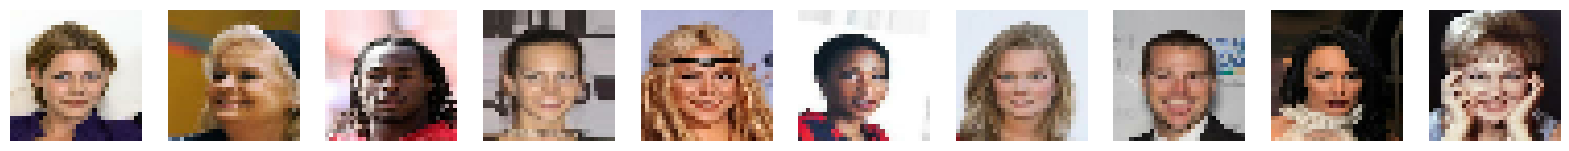

Reconstructions


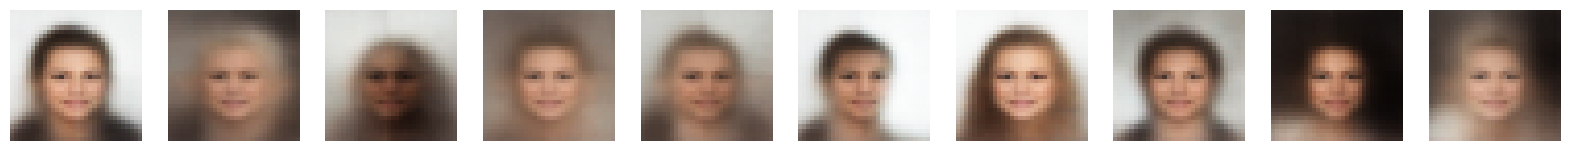

In [26]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

4/4 [==============================] - 0s 14ms/step


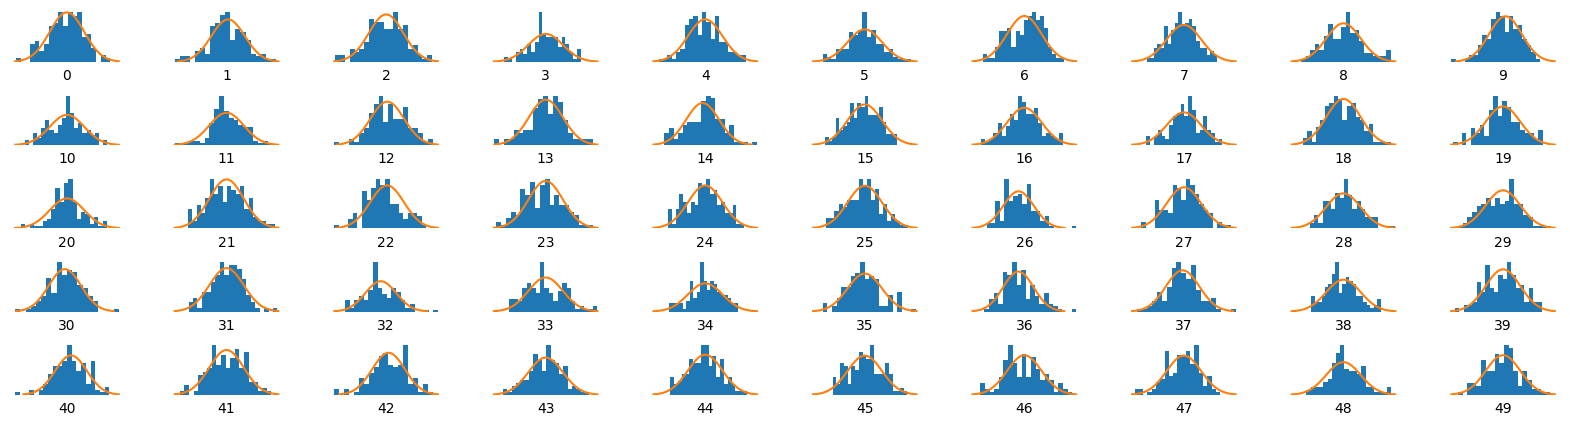

In [27]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

1/1 [==============================] - 0s 410ms/step


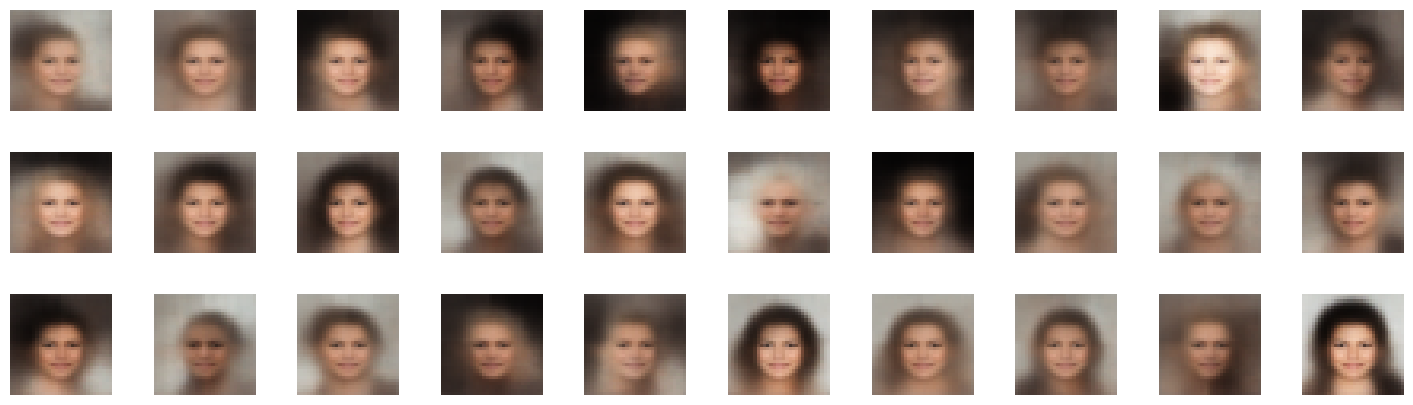

In [30]:
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 200))

reconstructions = decoder.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])